In [1]:
import pandas as pd
import numpy as np
import math
from math import ceil
import random
import argparse
import copy
import pickle
import gc
import os

## Import custom parts of the project
#import data
#import models
#import roc
#import constants as const
#import notify

from typing import TextIO, Callable, Collection, Dict, Iterator, List, Tuple, Type, TypeVar

#from data import EyetrackingDataset

import matplotlib.pyplot as plt
from datetime import datetime
from scipy.stats import zscore
from scipy.stats import loguniform


from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import roc_curve, auc, RocCurveDisplay
from sklearn.ensemble import VotingClassifier
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import roc_auc_score

import torch
from torch import nn # nn contains all of PyTorch's building blocks for neural networks
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import Subset 
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
from torch.utils.data.dataloader import default_collate
import torch.nn.functional as F
import torch.optim as optim

BATCH_SUBJECTS = True
dropPhonologyFeatures = True
T = TypeVar("T", bound="EyetrackingClassifier")

ablation = False

In [2]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


In [3]:
# Version 2, has to go with new getmeansd()
def apply_standardization(x, m, sd):
    nonzero_sd = sd.clone()
    nonzero_sd[sd == 0] = 1
    x = torch.from_numpy(x).float()
    x_zeros = x[x.sum(dim=(1)) == 0]
    x_zeros[x_zeros==0] = -5
    x_non_zeros = x[x.sum(dim=(1)) != 0]
    x_non_zeros = (x_non_zeros - m.unsqueeze(0)) / nonzero_sd.unsqueeze(0)
    res = torch.cat((x_non_zeros, x_zeros), axis =0)
    return res
    

In [4]:
def aggregate_per_subject(subjs, y_preds, y_preds_class, y_trues):
    y_preds = np.array(y_preds)
    y_preds_class = np.array(y_preds_class)
    y_trues = np.array(y_trues)
    subjs = np.array(subjs).flatten()
    y_preds_subj = []
    y_preds_class_subj = []
    y_trues_subj = []
    subjs_subj = np.unique(subjs)
    for subj in subjs_subj:
        subj = subj.item()
        y_pred_class_subj = y_preds_class[subjs == subj]
        y_pred_subj = y_preds[subjs == subj]
        y_true_subj = y_trues[subjs == subj]
        assert len(np.unique(y_true_subj)) == 1, f"No unique label: subj={subj}"
        y_trues_subj.append(np.unique(y_true_subj).item())
        y_preds_subj.append(np.mean(y_pred_subj).item())
        if sum(y_pred_class_subj) >= (len(y_pred_class_subj) / 2):
            y_preds_class_subj.append(1)
        else:
            y_preds_class_subj.append(0)
    return subjs_subj, y_preds_subj, y_preds_class_subj, y_trues_subj

def aggregate_speed_per_subject(subjs, y_preds, y_trues):
    y_preds = np.array(y_preds)
    #y_preds_class = np.array(y_preds_class)
    y_trues = np.array(y_trues)
    subjs = np.array(subjs).flatten()
    y_preds_subj = []
    y_trues_subj = []
    subjs_subj = np.unique(subjs)
    for subj in subjs_subj:
        subj = subj.item()
        y_pred_subj = y_preds[subjs == subj]
        y_true_subj = y_trues[subjs == subj]
        assert len(np.unique(y_true_subj)) == 1, f"No unique label: subj={subj}"
        y_trues_subj.append(np.unique(y_true_subj).item())
        y_preds_subj.append(np.mean(y_pred_subj).item())

    return subjs_subj, y_preds_subj, y_trues_subj

def getmeansd(dataset, batch: bool = False):  # removing rows of 0s
    if batch:
        # Anna added preprocessing from ndarray to torch
        tensors = [X for X, _, _, _ in dataset]  #torch.from_numpy(X).float()
        tensors = torch.cat(tensors, axis=0)
        # remove padded tensors
        tensors = tensors[tensors.sum(dim=(1,2)) != 0]   #tensors[tensors.sum(dim=(1, 2)) != 0]
        # remove rows of 0s from the computation
        sentences, timesteps, features = tensors.size()
        subset = tensors.sum(dim=(2)) != 0
        subset = subset.view(sentences, timesteps, 1)
        subset = subset.expand(sentences, timesteps, features)
        result = tensors[subset].view(-1, features) 
        
        means = torch.mean(result, dim=(0))
        sd = torch.std(result, dim=(0))
        return means, sd
    else:
        tensors = [torch.from_numpy(X).float() for X, _, _, _ in dataset] # Anna added , was [X for X, _, _ in dataset]
        tensors = torch.cat(tensors, axis=0)
        # remove padded tensors
        tensors = tensors[tensors.sum(dim=1) != 0]
        means = torch.mean(tensors, 0)
        sd = torch.std(tensors, 0)
        return means, sd
    
    
def get_params(paramdict) -> dict:
    selected_pars = dict()
    for k in paramdict:
        selected_pars[k] = random.sample(list(paramdict[k]), 1)[0]
    return selected_pars

In [5]:
class EyetrackingDataPreprocessor(Dataset):
    """Dataset with the long-format sequence of fixations made during reading by dyslexic 
    and normally-developing Russian-speaking monolingual children."""

    def __init__(
        self, 
        csv_file, 
        transform=None, 
        target_transform=None, 
        dropPhonologyFeatures = True, 
        dropPhonologySubjects = True,     
        num_folds: float = 10,
        ):
        """
        Arguments:
            csv_file (string): Path to the csv file with annotations.
            transform (callable, optional): Optional transform to be applied
                on a sample.
            target_transform (callable, optional): Optional transform to be applied
                on a label.
        """
        data = pd.read_csv(csv_file)
        
        # changing dyslexia labels to 0 and 1
        data['group'] = data['group'] + 0.5
        
        # log-transforming frequency
        to_transform = ['frequency', 'predictability', 'fix_dur'] #
        for column in to_transform:
            data[column] = data[column].apply(lambda x: np.log(x) if x > 0 else 0) 
        
        # drop reading speed, the main basis of classification
        data = data.drop(columns = ['fix_x', 'fix_y', 'fix_index'])  
        
        data['Reading_speed'] = (data['Reading_speed'] - data['Reading_speed'].mean())/data['Reading_speed'].std(ddof=0)
        
        if ablation == True:
            data = data.drop(columns = ['sex', 'Grade'])
            convert_columns = ['direction']
        else:
            convert_columns = ['Grade', 'direction'] 
        
        if dropPhonologyFeatures == True:
            data = data.drop(columns = ['IQ', 'Sound_detection', 'Sound_change'])
        
        for column in convert_columns:
            prefix = column + '_dummy'
            data = pd.concat([data, pd.get_dummies(data[column], 
                                    prefix=prefix)], axis=1)
            data = data.drop(columns = column)
        data = data.drop(columns = ['Grade_dummy_0', 'direction_dummy_0'])
            
        if dropPhonologySubjects == True:
            # Drop subjects
            data.dropna(axis = 0, how = 'any', inplace = True)
        else:
            # Drop columns
            data.dropna(axis = 1, how = 'any', inplace = True)
            
        # rearrange columns (I need demogrpahic information to come last)
        cols = ['item', 'subj', 'group', 'Reading_speed', 'fix_dur', 'landing', 'word_length',
                 'predictability', 'frequency', 'number.morphemes', 'next_fix_dist',
                 'sac_ampl', 'sac_angle', 'sac_vel', 'rel.position', 'direction_dummy_DOWN',
                 'direction_dummy_LEFT', 'direction_dummy_RIGHT', 'direction_dummy_UP',
                 'sex', 'Age', 'Grade_dummy_1', 'Grade_dummy_2', 'Grade_dummy_3', 'Grade_dummy_4',
                 'Grade_dummy_5', 'Grade_dummy_6']
        data = data[cols]
        
        # Record features that are used for prediction
        self._features = [i for i in data.columns if i not in ['group', 'item', 'subj', 'Reading_speed']]
        self._data = pd.DataFrame()
        # Add sentence IDs and subject IDs
        self._data["sn"] = data["item"]
        self._data["subj"] = data["subj"]
        # Add labels
        self._data["group"] = data["group"]
        self._data["reading_speed"] = data["Reading_speed"]
        
        # Add features used for prediction
        for feature in self._features:
            self._data[feature] = data[feature]

        # Distribute subjects across stratified folds
        self._num_folds = num_folds
        self._folds = [[] for _ in range(num_folds)]
        dyslexic_subjects = self._data[self._data["group"] == 1]["subj"].unique()
        control_subjects = self._data[self._data["group"] == 0]["subj"].unique()
        random.shuffle(dyslexic_subjects)
        random.shuffle(control_subjects)
        for i, subj in enumerate(dyslexic_subjects):
            self._folds[i % num_folds].append(subj)
        for i, subj in enumerate(control_subjects):
            self._folds[num_folds - 1 - i % num_folds].append(subj)
        for fold in self._folds:
            random.shuffle(fold)

    def _iter_trials(self, folds: Collection[int]) -> Iterator[pd.DataFrame]:
        # Iterate over all folds
        for fold in folds:
            # Iterate over all subjects in the fold
            for subj in self._folds[fold]:       # Anna: subj in fold?
                subj_data = self._data[self._data["subj"] == subj]
                # Iterate over all sentences this subject read
                for sn in subj_data["sn"].unique():
                    trial_data = subj_data[subj_data["sn"] == sn]
                    yield trial_data
                    
                    
    def iter_folds(
        self, folds: Collection[int]) -> Iterator[Tuple[torch.Tensor, torch.Tensor, int]]:
        for trial_data in self._iter_trials(folds):
            predictors = trial_data[self._features].to_numpy()
            #predictors = np.reshape(predictors, (int(len(predictors)/278), 278, predictors.shape[1]))
            label = trial_data["group"].unique().item()
            subj = trial_data["subj"].unique().item()
            reading_speed = trial_data["reading_speed"].unique().item()
            #  X = (time_steps, features)
            X = predictors
            y = torch.tensor(label, dtype=torch.float)
            rs = torch.tensor(reading_speed , dtype=torch.float)
            yield X, y, subj, rs
                    

    @property
    def num_features(self) -> int:
        """Number of features per word (excluding word vector dimensions)."""
        return len(self._features)
    

    @property
    def max_number_of_sentences(self):
        data_copy = self._data.copy()
        max_s_count = data_copy.groupby(by="subj").sn.unique()
        return max([len(x) for x in max_s_count])

        

In [6]:
class EyetrackingDataset(Dataset):
    def __init__(
        self,
        preprocessor: EyetrackingDataPreprocessor,
       # word_vector_model: WordVectorModel,
        folds: Collection[int],
        batch_subjects: bool = False,
    ):
        self.sentences = list(preprocessor.iter_folds(folds))
        self._subjects = list(np.unique([subj for _, _, subj, _ in self.sentences]))
        self.num_features = preprocessor.num_features# + word_vector_model.dimensions()
        self.batch_subjects = batch_subjects
        #self.max_sentence_length = preprocessor.max_sentence_length
        self.max_number_of_sentences = preprocessor.max_number_of_sentences

    def __getitem__(self, index: int) -> Tuple[torch.Tensor, torch.Tensor, int]:
        if self.batch_subjects:
            subject = self._subjects[index]
            subject_sentences = [
                (X, y, subj, rs) for X, y, subj, rs in self.sentences if subj == subject
            ]
            X = torch.stack([torch.FloatTensor(X) for X, _, _, _ in subject_sentences]) #[X for X, _, _ in subject_sentences] #torch.FloatTensor([X for X, _, _ in subject_sentences])
            y = torch.stack([y for _, y, _, _ in subject_sentences]).unique().squeeze() 
            rs = torch.stack([rs for _, _, _, rs in subject_sentences]).unique().squeeze()
            return X, y, subject, rs

        else:
            X, y, subj, rs = self.sentences[index]
            #X = torch.from_numpy(X).float()   
            return X, y, subj, rs

    def __len__(self) -> int:
        if self.batch_subjects:
            return len(self._subjects)
        else:
            return len(self.sentences)

    def standardize(self, mean: torch.Tensor, sd: torch.Tensor):
        self.sentences = [
            (apply_standardization(X, mean, sd), y, subj, rs)
            for X, y, subj, rs in self.sentences
        ]
        

In [7]:
class EyetrackingClassifier(nn.Module):
    def __init__(self, input_size: int, config):
        super().__init__()
        self.initialize_model(input_size, config)
        self.config = config

    def initialize_model(self, input_size: int, config):
        raise NotImplementedError()

    def forward(self, input: torch.Tensor) -> torch.Tensor:
        raise NotImplementedError()

    def _predict(self, X: torch.Tensor, subj_mean: bool = False, pretrain: bool = False) -> torch.Tensor:
        if pretrain:
            y_preds = self(X, pretrain=True)
            # return predictions for all 12 features
            return y_preds
        if subj_mean:
            # X = (batch_size, sentences, time_steps, features)
            X_flat = X.view(X.size(0) * X.size(1), X.size(2), X.size(3))
            # X_flat = (batch_size*sentences, time_steps, features)
            y_pred_flat = self(X_flat, pretrain)
            # y_pred_flat = (batch_size*sentences)
            y_pred = y_pred_flat.view(X.size(0), X.size(1))
            # y_pred = (batch_size, sentences)
            final_predictions = []
            for batch_X, batch_y_pred in zip(X, y_pred):
                batch_predictions = []
                for sentence_X, sentence_y_pred in zip(batch_X, batch_y_pred):
                    if (
                        sentence_X.count_nonzero() > 0
                    ):  # Ignore the padding sentences
                        batch_predictions.append(sentence_y_pred)
                final_predictions.append(torch.mean(torch.stack(batch_predictions)))
            final_y_pred = torch.stack(final_predictions)
            return final_y_pred
        else:
            y_pred = self(X, pretrain)
            return y_pred

#     @classmethod
#     def pretrain_model(
#         cls: Type[T],
#         data: PretrainingDataset,
#         epochs: int = 50,
#         device: str = "cuda",
#         config=None,
#         patience=20,   # was 40
#         **kwargs,
#     ) -> Tuple[T, int]:
#         model = cls(data.num_features, config, **kwargs)
#         model.to(device)
#         model.train()
#         optimizer = optim.Adam(model.parameters(), lr=config["lr"])
#         epoch_count = 0
#         best_losses = [float("inf")] * patience
#         for epoch in range(epochs):
#             loader = torch.utils.data.DataLoader(
#                 data,
#                 batch_size=config["batch_size"],
#                 shuffle=True,
#                 # drop_last=True,
#             )
#             epoch_count += 1
#             epoch_loss = 0
#             for X, y, _ in loader:
#                 X = X.to(device)
#                 y = y.to(device)
#                 optimizer.zero_grad()
#                 y_pred = model._predict(X, pretrain=True) #model._predict(X, subj_mean=BATCH_SUBJECTS).squeeze()
#                 loss = F.mse_loss(y_pred, y) # what is F? (y_pred, y.squeeze())
#                 loss.backward()
#                 optimizer.step()
#                 epoch_loss += loss.item()
#             # print(f"Pretraining: Epoch {epoch} done. Loss: {epoch_loss}")
#             if all(epoch_loss > i for i in best_losses):
#                 #epoch_count -= patience - best_losses.index(min(best_losses)) # Anna added, otherwise why is patience even needed
#                 break
#             else:
#                 best_losses.pop(0)
#                 best_losses.append(epoch_loss)
#         return model
 

    @classmethod
    def train_model(
        cls: Type[T],
        data: EyetrackingDataset,
        min_epochs: int = 15,
        max_epochs: int = 200,
        dev_data: EyetrackingDataset = None,
        device: str = "cuda",
        config=None,
        patience=10,
        pretrained_model: T = None,
        **kwargs,
    ) -> Tuple[T, int]:
        model = pretrained_model or cls(data.num_features+1, config, **kwargs) #LSTMClassifier()
        model.to(device)
        model.train()
        optimizer = optim.Adam(model.parameters(), lr=config["lr"])
        epoch_count = 0
        best_losses = [float("inf")] * patience
        for epoch in range(max_epochs):
            # reshuffle data in each epoch
            loader = torch.utils.data.DataLoader(
                data,
                batch_size=config["batch_size"],
                shuffle=True,
                # drop_last=True
            )
            epoch_count += 1
            epoch_loss = 0
            for X_o, y, subj, _ in loader:
                X_o = X_o.to(device)
                y = y.to(device)

                # adding predicted reading speed to X
                x = torch.empty(X_o.size(0), X_o.size(1), X_o.size(2), X_o.size(3)+1)
                for index in range(len(subj)):
                    pred_speed = float(reading_speed.loc[subj[index]])
                    x[index] = F.pad(input=X_o[index], pad=(0, 1, 0,0), mode='constant', value=pred_speed)
                X = x.to(device)
                #########
                
                optimizer.zero_grad()
                y_logits = model._predict(X.to(device), subj_mean=BATCH_SUBJECTS).squeeze() # why do I need to squeeze here? I did not need in the simple model
                #y_pred = torch.round(torch.sigmoid(y_logits))
                
                loss = loss_fn(y_logits, y.squeeze()) # Using nn.BCEWithLogitsLoss works with raw logits
                loss.backward()
                optimizer.step()
                epoch_loss += loss.item()
            # print(f"Epoch {epoch} done. Loss: {epoch_loss}")
            if dev_data is not None:
                dev_accuracy = model.evaluate(dev_data, metric="loss", device=device)
                model.train()
                # print(f"Dev loss: {dev_accuracy} in Epoch {epoch}")
                if epoch > min_epochs and all(dev_accuracy > i for i in best_losses):
                    epoch_count -= patience - best_losses.index(min(best_losses))
                    break
                else:
                    best_losses.pop(0)
                    best_losses.append(dev_accuracy)
        return model

    def predict_probs(
        self,
        data: EyetrackingDataset,
        device: str = "cuda",
        per_subj: bool = True,
    ):
        self.to(device)
        self.eval()
        loader = torch.utils.data.DataLoader(data)
        y_preds_class = []
        y_preds = []
        y_trues = []
        subjs = []
        for X_o, y, subj, _ in loader:
            X_o = X_o.to(device)
            y = y.to(device)

            # adding predicted reading speed to X
            x = torch.empty(X_o.size(0), X_o.size(1), X_o.size(2), X_o.size(3)+1)
            for index in range(len(subj)):
                pred_speed = float(reading_speed.loc[subj[index]])
                x[index] = F.pad(input=X_o[index], pad=(0, 1, 0,0), mode='constant', value=pred_speed)
            X = x.to(device)
            #########
            
            y_logits = self._predict(X, subj_mean=data.batch_subjects).squeeze()   # why do I need to squeeze here? I did not need in the simple model
            y_pred = torch.round(torch.sigmoid(y_logits)).squeeze()
            
            #y_pred = self._predict(X, subj_mean=data.batch_subjects)
            #y_pred = torch.round(torch.sigmoid(y_pred))   # Anna added
            
            y_preds.append(torch.sigmoid(y_logits).item())  ### EXPERIMENTING
            #y_preds.append(y_pred.item())  #### WAS THIS
            
            y_preds_class.append(round(y_pred.item()))
            y_trues.append(int(y.item()))
            subjs.append(subj)
        if per_subj:
            subjs, y_preds, y_preds_class, y_trues = aggregate_per_subject(
                subjs, y_preds, y_preds_class, y_trues
            )
        return y_preds, y_trues, subjs

    def evaluate(
        self,
        data: EyetrackingDataset,
        metric: str = "accuracy",
        print_report: bool = False,
        save_errors: TextIO = None,
        per_subj: bool = False,
        device: str = "cuda",
    ) -> Tuple[float, float, float, float]:
        self.to(device)
        self.eval()
        loader = torch.utils.data.DataLoader(data)
        y_preds_class = []
        y_preds = []
        y_trues = []
        subjs = []
        loss = 0
        for X_o, y, subj, _ in loader:
            X_o = X_o.to(device)
            y = y.to(device)

            # adding predicted reading speed to X
            x = torch.empty(X_o.size(0), X_o.size(1), X_o.size(2), X_o.size(3)+1)
            for index in range(len(subj)):
                pred_speed = float(reading_speed.loc[subj[index]])
                x[index] = F.pad(input=X_o[index], pad=(0, 1, 0,0), mode='constant', value=pred_speed)
            X = x.to(device)
            #########
            
            y_logits = self._predict(X, subj_mean=BATCH_SUBJECTS).squeeze()
            y_pred = torch.round(torch.sigmoid(y_logits)) 
            loss += loss_fn(y_logits, y.squeeze()).item() 
            
            y_preds.append(torch.sigmoid(y_logits).item())  ### EXPERIMENTING
            #y_preds.append(y_pred.item())  #### WAS THIS
            # TODO CHECK IF CORRECT
            y_preds_class.append(1 if y_pred.item() >= self.config['decision_boundary'] else 0)
            # y_preds_class.append(round(y_pred.item()))
            y_trues.append(int(y.item())) 
            subjs.append(subj) 
        if per_subj:
            subjs, y_preds, y_preds_class, y_trues = aggregate_per_subject(
                subjs, y_preds, y_preds_class, y_trues
            )
        if print_report:
            print(
                metrics.classification_report(y_trues, y_preds_class, zero_division=0)
            )
        if save_errors is not None:
            for subj, y_pred, y_pred_class, y_true in zip(subjs, y_preds, y_preds_class, y_trues):
                if y_pred_class != y_true:
                    save_errors.write(f"{subj},{y_pred},{y_true}\n")
        if metric == "accuracy":
            return metrics.accuracy_score(y_trues, y_preds_class)
        elif metric == "loss":
            return loss
        elif metric == "f1":
            return metrics.f1_score(y_trues, y_preds_class, zero_division= np.nan) # zero_division = 0 previously
        elif metric == "auc": # Anna added
            return metrics.roc_auc_score(y_trues, y_preds_class) 
        elif metric == "all":
            return (
                metrics.accuracy_score(y_trues, y_preds_class),
                metrics.precision_score(y_trues, y_preds_class, zero_division=np.nan), # zero_division = 0 previously
                metrics.recall_score(y_trues, y_preds_class, zero_division=np.nan),  # zero_division = 0 previously
                metrics.f1_score(y_trues, y_preds_class, zero_division=np.nan),  # zero_division = 0 previously
            )
        else:
            raise ValueError(f"Unknown metric '{metric}'")

In [8]:
# Now, I need to add this info to the model input
class LSTMClassifier(EyetrackingClassifier):
    def initialize_model(self, input_size: int, config):
        self.lstm = nn.LSTM(input_size-(NUM_DEMOGR_FEATURES), config["lstm_hidden_size"], 
                            batch_first=True, bidirectional=True) 
        self.linear1 = nn.Linear(config["lstm_hidden_size"] + (NUM_DEMOGR_FEATURES), 20)
        self.linear2 = nn.Linear(20, 10)
        self.linear3 = nn.Linear(10, 1)
        self.dropout = nn.Dropout(0.20) 

    def forward(self, input: torch.Tensor, pretrain: bool = False) -> torch.Tensor:
        demo = input[:, 0, -(NUM_DEMOGR_FEATURES):] # only one time step is needed, demography is the same across time steps
        lstm_output, (lstm_hidden, lstm_cell) = self.lstm(input[:,:,:-(NUM_DEMOGR_FEATURES)])
        lstm_hidden = lstm_hidden.mean(0)
        linear_input = torch.cat((lstm_hidden, demo), dim=1)
        linear1_output = self.linear1(linear_input)
        linear2_output = self.linear2(linear1_output)
        if pretrain:
            linear_output = linear1_output.squeeze(1)
        else:
            linear_output = self.linear3(linear2_output) 
        return linear_output

### The new pieces - start

In [9]:
class RSClassifier(nn.Module):
    def __init__(self, input_size: int, config):
        super().__init__()
        self.initialize_model(input_size, config)
        self.config = config

    def initialize_model(self, input_size: int, config):
        raise NotImplementedError()

    def forward(self, input: torch.Tensor) -> torch.Tensor:
        raise NotImplementedError()

    def _predict(self, X: torch.Tensor, subj_mean: bool = False, pretrain: bool = False) -> torch.Tensor:
        if pretrain:
            y_preds = self(X, pretrain=True)
            # return predictions for all 12 features
            return y_preds
        if subj_mean:
            # X = (batch_size, sentences, time_steps, features)
            X_flat = X.view(X.size(0) * X.size(1), X.size(2), X.size(3))
            # X_flat = (batch_size*sentences, time_steps, features)
            y_pred_flat = self(X_flat, pretrain)
            # y_pred_flat = (batch_size*sentences)
            y_pred = y_pred_flat.view(X.size(0), X.size(1))
            # y_pred = (batch_size, sentences)
            final_predictions = []
            for batch_X, batch_y_pred in zip(X, y_pred):
                batch_predictions = []
                for sentence_X, sentence_y_pred in zip(batch_X, batch_y_pred):
                    if (
                        sentence_X.count_nonzero() > 0
                    ):  # Ignore the padding sentences
                        batch_predictions.append(sentence_y_pred)
                final_predictions.append(torch.mean(torch.stack(batch_predictions)))
            final_y_pred = torch.stack(final_predictions)
            return final_y_pred
        else:
            y_pred = self(X, pretrain)
            return y_pred
 

    @classmethod
    def train_model(
        cls: Type[T],
        data: EyetrackingDataset,
        min_epochs: int = 15,
        max_epochs: int = 200,
        dev_data: EyetrackingDataset = None,
        device: str = "cuda",
        config=None,
        patience=10,
        pretrained_model: T = None,
        **kwargs,
    ) -> Tuple[T, int]:
        model = pretrained_model or cls(data.num_features, config, **kwargs) #LSTMClassifier()
        model.to(device)
        model.train()
        optimizer = optim.Adam(model.parameters(), lr=config["lr"])
        epoch_count = 0
        best_losses = [float("inf")] * patience
        for epoch in range(max_epochs):
            # reshuffle data in each epoch
            loader = torch.utils.data.DataLoader(
                data,
                batch_size=config["batch_size"],
                shuffle=True,
                # drop_last=True
            )
            epoch_count += 1
            epoch_loss = 0
            for X, _, _, y in loader:
                X = X.to(device)
                y = y.to(device)
                optimizer.zero_grad()
                
                y_pred = model._predict(X, subj_mean=BATCH_SUBJECTS).squeeze() # why do I need to squeeze here? I did not need in the simple model

                loss = loss_fn(y_pred, y.squeeze())
                loss.backward()
                optimizer.step()
                epoch_loss += loss.item()/len(X)  
            mean_loss = epoch_loss/len(loader)
            # print(f"Epoch {epoch} done. Loss: {epoch_loss}")
            if dev_data is not None:
                dev_accuracy = model.evaluate(dev_data, metric="loss", device=device)
                model.train()
                # print(f"Dev loss: {dev_accuracy} in Epoch {epoch}")
                if epoch > min_epochs and all(dev_accuracy > i for i in best_losses):
                    epoch_count -= patience - best_losses.index(min(best_losses))
                    break
                else:
                    best_losses.pop(0)
                    best_losses.append(dev_accuracy)
        return model

    def predict_probs(
        self,
        data: EyetrackingDataset,
        device: str = "cuda",
        per_subj: bool = True,
    ):
        self.to(device)
        self.eval()
        loader = torch.utils.data.DataLoader(data)
        y_preds = []
        y_trues = []
        subjs = []
        for X, _, subj, y in loader:
            X = X.to(device)
            y = y.to(device)
            y_pred = self._predict(X, subj_mean=data.batch_subjects).squeeze()   # why do I need to squeeze here? I did not need in the simple model
            
            y_preds.append(y_pred.item())
            y_trues.append(y.item())
            subjs.append(subj)
        if per_subj:
            subjs, y_preds, y_trues = aggregate_speed_per_subject(
                subjs, y_preds, y_trues
            )
        return y_preds, y_trues, subjs

    def evaluate(
        self,
        data: EyetrackingDataset,
        metric: str = "loss",
        print_report: bool = False,
        save_errors: TextIO = None,
        per_subj: bool = False,
        device: str = "cuda",
    ) -> Tuple[float, float, float, float]:
        self.to(device)
        self.eval()
        loader = torch.utils.data.DataLoader(data)
        y_preds = []
        y_trues = []
        subjs = []
        loss = 0
        for X, _, subj, y in loader:
            X = X.to(device)
            y = y.to(device)
            y_pred = self._predict(X, subj_mean=BATCH_SUBJECTS).squeeze()
            batch_loss = loss_fn(y_pred, y.squeeze())
            loss += batch_loss.item()/len(X)     
            
            y_preds.append(y_pred.item())  
            y_trues.append(y.item()) 
            subjs.append(subj) 
        mean_loss = loss/len(loader)
        if per_subj:
            subjs, y_preds, y_trues = aggregate_speed_per_subject(
                subjs, y_preds, y_trues
            )
#         if print_report:
#             print(
#                 metrics.classification_report(y_trues, y_preds_class, zero_division=0)
#             )
#         if save_errors is not None:
#             for subj, y_pred, y_true in zip(subjs, y_preds,  y_trues):
#                 if y_pred_class != y_true:
#                     save_errors.write(f"{subj},{y_pred},{y_true}\n")
        if metric == "loss":
            return mean_loss
        else:
            raise ValueError(f"Unknown metric '{metric}'")

In [10]:
class LSTMClassifier_RS(RSClassifier):
    def initialize_model(self, input_size: int, config):
        self.lstm = nn.LSTM(input_size, config["lstm_hidden_size"], batch_first=True, bidirectional=True)  #50
        self.linear1 = nn.Linear(config["lstm_hidden_size"], 10)  #self.linear1 = nn.Linear(config["lstm_hidden_size"], 12)
        self.linear2 = nn.Linear(10, 5)
        self.linear3 = nn.Linear(5, 1)

    def forward(self, input: torch.Tensor, pretrain: bool = False) -> torch.Tensor:
        lstm_output, (lstm_hidden, lstm_cell) = self.lstm(input)
        lstm_hidden = lstm_hidden.mean(0)
        linear1_output = self.linear1(lstm_hidden)
        if pretrain:
            linear_output = linear1_output.squeeze(1)
        else:
            linear_output = self.linear3(self.linear2(linear1_output)).squeeze(1)  
         #   linear_output = torch.sigmoid(self.linear2(linear1_output).squeeze(1))
        return linear_output

### The new pieces -- end

In [11]:
## Constants
hyperparameter_space = {
    "lstm": {
        "batch_size": [64, 64],           #8, 16, 32, 64, 128
        "lr": [1e-02, 1e-03, 1e-04],     #np.linspace(1e-5, 1e-1, num=15),    #loguniform.rvs(1e-5, 1e-1, size=15)
        "lstm_hidden_size": [30, 40, 50],       #[10, 20, 30, 40, 50, 60, 70]
        "decision_boundary": [0.5, 0.5]      #np.random.uniform(0, 1, size=20)
    }
}

default_params = {
    "lstm": {
        "epochs": 40,
        "batch_size": 4,
        "lr": 0.001,
        "lstm_hidden_size": 50,
#        "decision_boundary": 0.5
    }
}



In [12]:
class ROC:
    def __init__(
        self,
        model,
        tune,
        mean_fpr=np.linspace(0, 1, 100),
        tprs: list = [],
        aucs: list = [],
        mean_auc: int = 0,
        std_auc: int = 0,
    ):
        self.tune = 'tuned' if tune else 'untuned'
        self.model = model
        self.title = f"LSTM performance"
        self.fig = plt.figure(figsize=(6, 6), dpi=300)
        self.ax = self.fig.add_subplot(111)
        self.tprs = tprs
        self.aucs = aucs
        self.mean_fpr = mean_fpr
        self.mean_auc = mean_auc
        self.std_auc = std_auc

    def update(self, tpr, auc):
        self.tprs.append(tpr)
        self.aucs.append(auc)

    def plot(self):
        self.ax.plot(
            [0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8
        )
        mean_tpr = np.mean(self.tprs, axis=0)
        mean_tpr[-1] = 1.0
        self.mean_auc = auc(self.mean_fpr, mean_tpr)
        self.std_auc = np.std(self.aucs)
        self.ax.plot(
            self.mean_fpr,
            mean_tpr,
            color="b",
            label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (self.mean_auc, self.std_auc),
            lw=2,
            alpha=0.8,
        )

        std_tpr = np.std(self.tprs, axis=0)
        tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
        tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
        self.ax.fill_between(
            self.mean_fpr,
            tprs_lower,
            tprs_upper,
            color="grey",
            alpha=0.2,
            label=r"$\pm$ 1 std. dev.",
        )

        self.ax.set(
            xlim=[-0.05, 1.05],
            ylim=[-0.05, 1.05],
            title=self.title,
        )
        # Shrink current axis by 20%
        box = self.ax.get_position()
        self.ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

        # Put a legend to the right of the current axis
        self.ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        #self.ax.legend(loc="lower right")

    def show(self):
        self.fig.show()

    def save(self):
        date = datetime.now().strftime("%Y%m%d-%H:%M")
        plt.savefig(f"roc_{date}_{self.model}_{self.tune}.png", bbox_inches="tight", dpi=500)

    def get_tprs_aucs(self, y_trues, y_preds, test_fold):
        fpr, tpr, _ = roc_curve(y_trues, y_preds, drop_intermediate=False)
        
        
        viz = RocCurveDisplay.from_predictions(
            y_trues,
            y_preds,
            name="ROC fold {}".format(test_fold + 1),
            alpha=0.3,
            lw=1,
            ax=self.ax,
        )
        interp_tpr = np.interp(self.mean_fpr, viz.fpr, viz.tpr)
        interp_tpr[0] = 0.0
        self.update(interp_tpr, viz.roc_auc)



Generating reading speed predictions
test fold  0
test fold  1
test fold  2
test fold  3
test fold  4
test fold  5
test fold  6
test fold  7
test fold  8
test fold  9
Reading speed predictions are ready
test fold  0
dev fold 1
tune set 0
tune set 20
dev fold 2
tune set 0
tune set 20
dev fold 3
tune set 0
tune set 20
dev fold 4
tune set 0
tune set 20
dev fold 5
tune set 0
tune set 20
dev fold 6
tune set 0
tune set 20
dev fold 7
tune set 0
tune set 20
dev fold 8
tune set 0
tune set 20
dev fold 9
tune set 0
tune set 20
test accuraccy fold  0
              precision    recall  f1-score   support

           0       0.79      1.00      0.88        22
           1       1.00      0.25      0.40         8

    accuracy                           0.80        30
   macro avg       0.89      0.62      0.64        30
weighted avg       0.84      0.80      0.75        30

test fold  1
dev fold 0
tune set 0
tune set 20
dev fold 2
tune set 0
tune set 20
dev fold 3
tune set 0
tune set 20
dev fold 4
tu

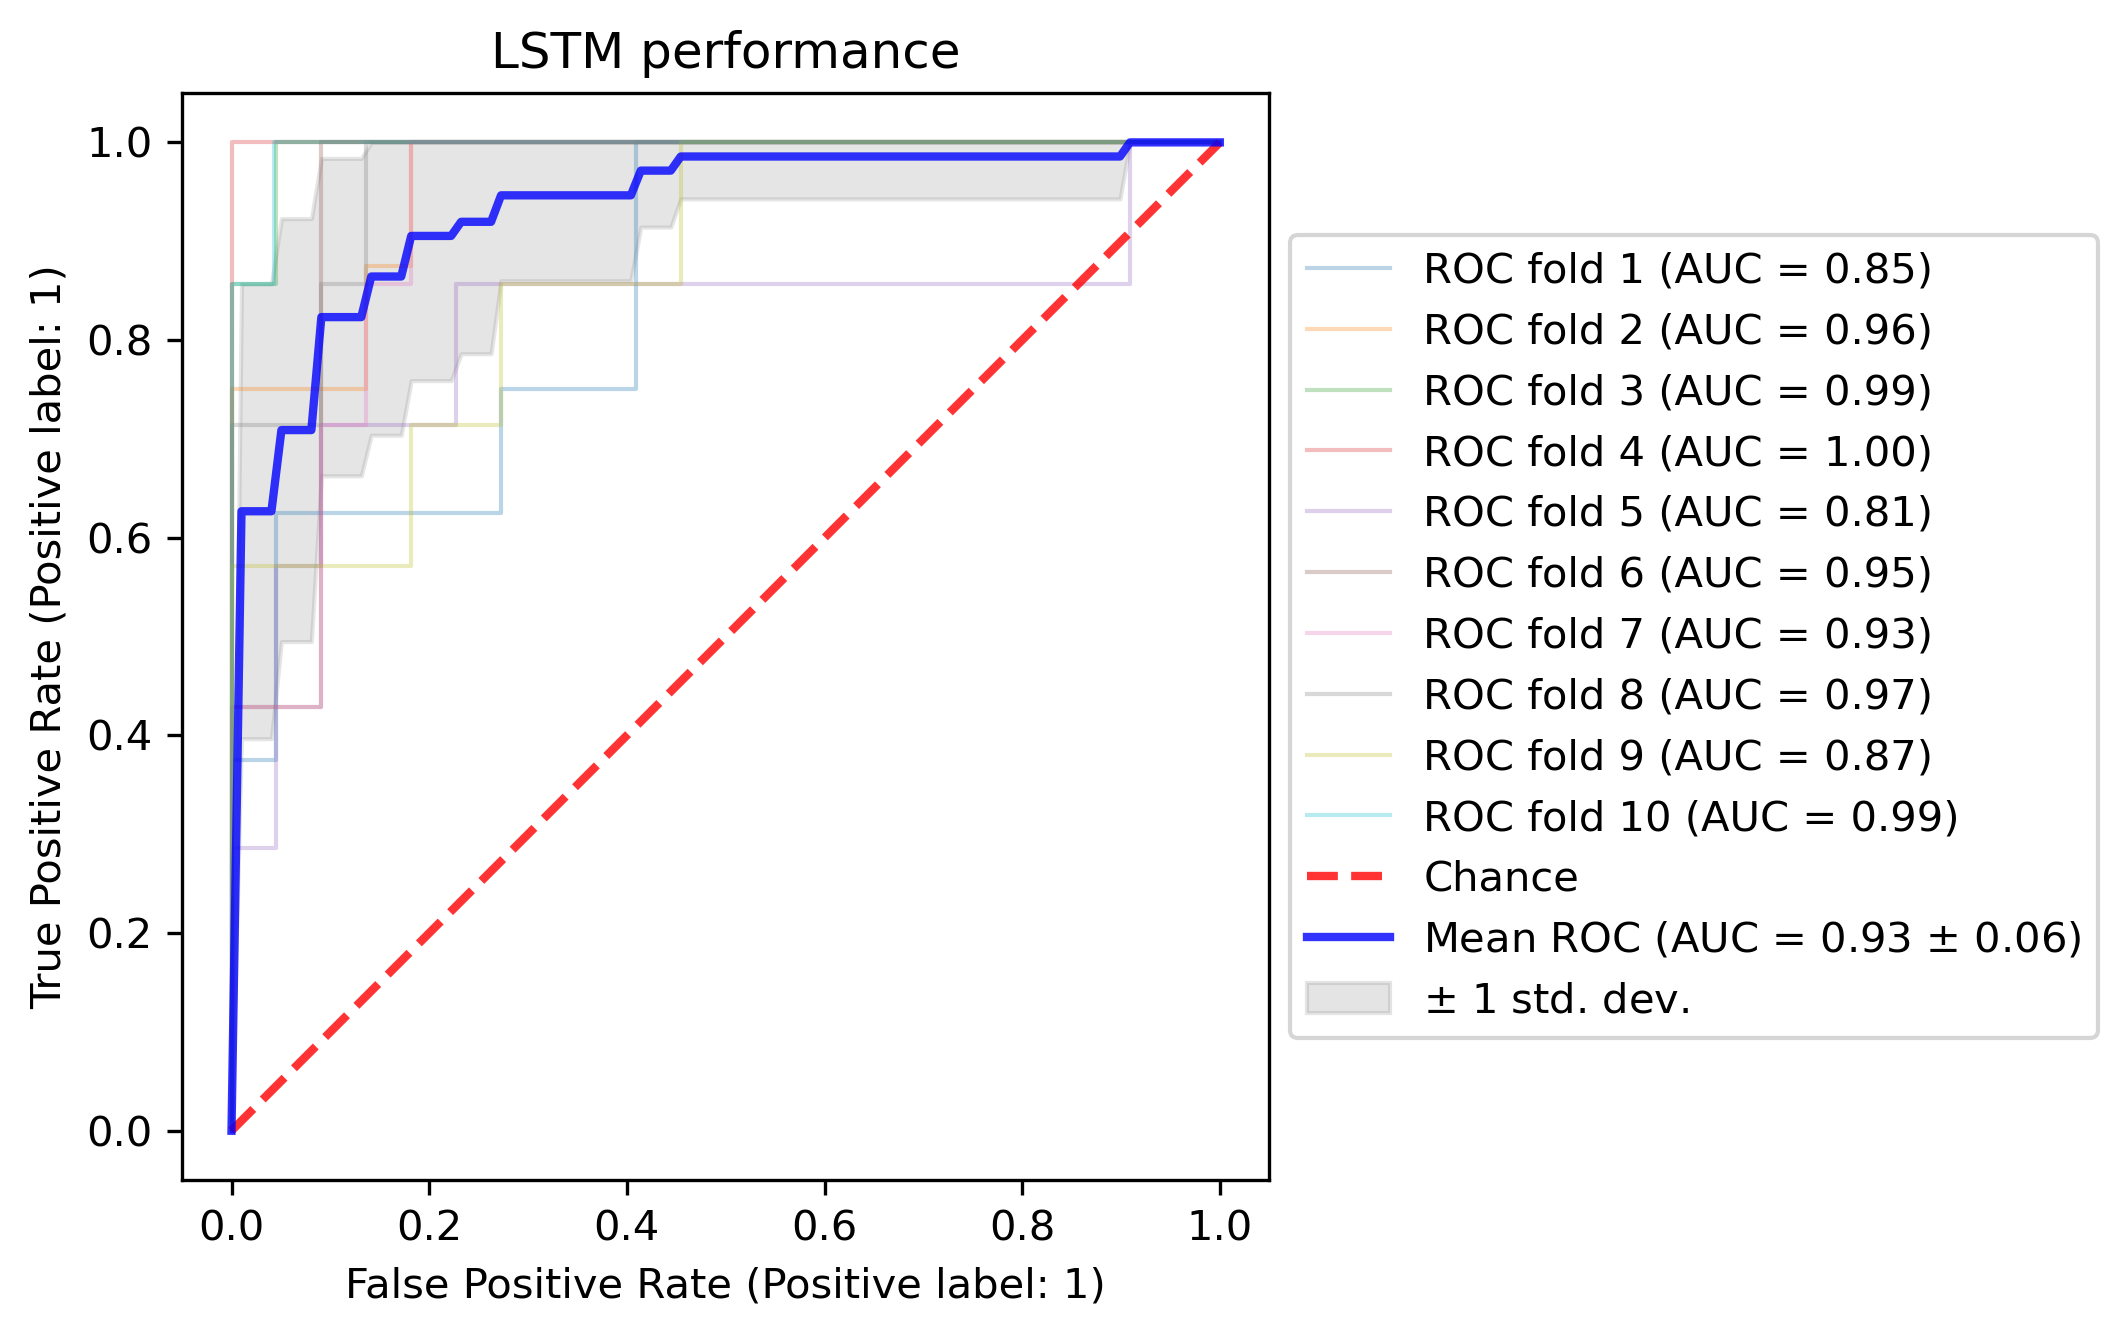

In [13]:
# default: --no-tune --wordvectors none --model cnn --subjpred
parser = argparse.ArgumentParser(description="Run Russian Dyslexia Experiments")
parser.add_argument("--model", dest="model")
parser.add_argument("--roc", dest="roc", action="store_true")
parser.add_argument("--no-roc", dest="roc", action="store_false")
parser.add_argument("--tunesets", type=int, default=35)
parser.add_argument("--tune", dest="tune", action="store_true")
parser.add_argument("--no-tune", dest="tune", action="store_false")
parser.add_argument("--wordvectors", type=str, default="none")
parser.add_argument("--pretrain", dest="pretrain", action="store_true")
parser.add_argument("--subjpred", dest="batch_subjects", action="store_false")
parser.add_argument("--textpred", dest="batch_subjects", action="store_true")
parser.add_argument("--save-errors", dest="save_errors", type=argparse.FileType("w"))
parser.add_argument("--seed", dest="seed", type=int, default=44)
parser.add_argument("--cuda", dest="cudaid", default=0)
parser.set_defaults(tune=True) #True
parser.set_defaults(roc=True)
parser.set_defaults(batch_subjects=True) #True
parser.set_defaults(model = "lstm")
args = parser.parse_args(args=[]) # modified to work with jupyter notebook

random.seed(args.seed)
np.random.seed(args.seed)
torch.manual_seed(args.seed)


if args.model == "lstm":
    MODEL_CLASS = LSTMClassifier 
    
device = "cuda" if torch.cuda.is_available() else "cpu"
if device == "cuda":
    device = torch.device(f'cuda:{args.cudaid}')
    
# saving weights
weights_directory = 'saved_models/baseline_demography_after_plus_predicted_rs/'
# saving everything for plotting
if BATCH_SUBJECTS:
    setting = "reader"
    folder = "reader_prediction_results/baseline_demography_after_plus_predicted_rs/"
else:
    setting = "sentence"
    folder = "sentence_prediction_results/"


    
NUM_FOLDS = 10
NUM_TUNE_SETS = args.tunesets
BATCH_SUBJECTS = args.batch_subjects
NUM_DEMOGR_FEATURES = 8 + 1 #(+1 for the predicted reading speed that gets added to X before the main LSTM trains)
tune = args.tune

# Prepare ROC Curves
if args.roc:
    Roc = ROC(args.model, args.tune)

if args.save_errors is not None:
    args.save_errors.write("subj,y_pred,y_true\n")

if tune:
    used_test_params = []
    parameter_sample = [
        get_params(hyperparameter_space[args.model]) for _ in range(NUM_TUNE_SETS)
    ]

    
tprs_folds = {}

# load and preprocess data for training
preprocessor = EyetrackingDataPreprocessor(
    csv_file = 'data/fixation_dataset_long_no_word_padded_word_pos.csv',  
    num_folds = NUM_FOLDS
)
######## Getting reading speed predictions ########
tprs_folds_rs = {}
params_test_rs = {"batch_size": 64, "decision_boundary": 0.5, "lr": 0.001, "lstm_hidden_size": 50}
loss_fn = nn.MSELoss()
running_model = copy.deepcopy(LSTMClassifier_RS)
#
print("Generating reading speed predictions")
for test_fold in range(NUM_FOLDS):
    print("test fold ", test_fold)
    dev_fold = (test_fold + 1) % NUM_FOLDS
    train_folds = [
        fold for fold in range(NUM_FOLDS) if fold != test_fold and fold != dev_fold
    ]
    train_dataset = EyetrackingDataset(
        preprocessor,
        folds=train_folds,
        batch_subjects=BATCH_SUBJECTS,
    )
    mean, sd = getmeansd(train_dataset, batch=BATCH_SUBJECTS)
    train_dataset.standardize(mean, sd)
    dev_dataset = EyetrackingDataset(
        preprocessor,
        folds=[dev_fold],
        batch_subjects=BATCH_SUBJECTS
    )
    dev_dataset.standardize(mean, sd)
    test_dataset = EyetrackingDataset(
        preprocessor,
        folds=[test_fold],
        batch_subjects=BATCH_SUBJECTS,
    )
    test_dataset.standardize(mean, sd)
    model = running_model.train_model(
        train_dataset,
        min_epochs=15,
        max_epochs=200,
        dev_data=dev_dataset,
        device=device,
        config=params_test_rs,
    )
    y_preds, y_trues, subjs = model.predict_probs(
        test_dataset,
        device=device,
        per_subj=BATCH_SUBJECTS,
    )
    tprs_folds_rs[str(test_fold)] = (y_trues, y_preds, subjs)
    
pred_speed = []
subjs = []

for fold in tprs_folds_rs:
    pred_speed.extend(tprs_folds_rs[fold][1])
    subjs.extend(tprs_folds_rs[fold][2])

reading_speed = pd.DataFrame({'Reading_speed':pred_speed, 'subj':subjs})
reading_speed = reading_speed.set_index('subj')
print("Reading speed predictions are ready")

###################################
# Main training and evaluation
###################################
loss_fn = nn.BCEWithLogitsLoss()
test_accuracies = []
for test_fold in range(NUM_FOLDS):
    print("test fold ", test_fold)
    parameter_evaluations = np.zeros(shape=(NUM_FOLDS, NUM_TUNE_SETS))
    if tune:
        # Normal training / fine-tuning
        for dev_fold in range(NUM_FOLDS):
            if args.pretrain:
                pretrained_models = next(pretrained_model_generator)
            if dev_fold == test_fold:
                continue
            print(f'dev fold {dev_fold}')
            train_folds = [
                fold
                for fold in range(NUM_FOLDS)
                if fold != test_fold and fold != dev_fold
            ]
    #             word_vector_model = preprocessor.train_word_vector_model(
    #                     folds=train_folds
    #                 )
            # When fine-tuning, we use the pre-trained word vector model (?)
            train_dataset = EyetrackingDataset(
                preprocessor,
                folds=train_folds,
                batch_subjects=BATCH_SUBJECTS,
            )
            mean, sd = getmeansd(train_dataset, batch=BATCH_SUBJECTS)
            train_dataset.standardize(mean, sd)
            dev_dataset = EyetrackingDataset(
                preprocessor,
                folds=[dev_fold],
                batch_subjects=BATCH_SUBJECTS,
            )
            dev_dataset.standardize(mean, sd)
            for tune_set in range(NUM_TUNE_SETS):
                running_model = copy.deepcopy(MODEL_CLASS)
                if tune_set%20 == 0:
                    print(f'tune set {tune_set}')
                if args.pretrain:
                    pretrained_model = next(pretrained_models)
                else:
                    pretrained_model = None
                model = None
                gc.collect()
                model = running_model.train_model(
                    train_dataset,
                    min_epochs=15,
                    max_epochs=200,
                    dev_data=dev_dataset,
                    pretrained_model=pretrained_model,
                    device=device,
                    config=parameter_sample[tune_set],
                )
                tune_accuracy = model.evaluate(
                    data=dev_dataset,
                    device=device,
                    metric="auc",
                    per_subj=BATCH_SUBJECTS,
                )
                parameter_evaluations[dev_fold, tune_set] = tune_accuracy
        # Select best parameter set
        mean_dev_accuracies = np.mean(parameter_evaluations, axis=0)
        best_parameter_set = np.argmax(mean_dev_accuracies)
        params_test = parameter_sample[best_parameter_set]
        # print(f'best performing parameter for fold ', test_fold, ": ", params_test)
        used_test_params.append(params_test)
        if args.pretrain:
            pretrained_model = copy.deepcopy(MODEL_CLASS)
            best_pretrained_model = pretrained_model.pretrain_model(
                        pretrain_dataset,
                        epochs=100,
                        device=device,
                        config=params_test,
                    )
        else:
            best_pretrained_model = None
    else:  # (not tuning)
        params_test = default_params[args.model]
        best_pretrained_model = None
    # If tune: train using best feature set over dev sets, else: train using default parameters
    # Use fold next to test fold for early stopping
    running_model = copy.deepcopy(MODEL_CLASS)
    dev_fold = (test_fold + 1) % NUM_FOLDS
    train_folds = [
        fold for fold in range(NUM_FOLDS) if fold != test_fold and fold != dev_fold
    ]
    #word_vector_model = preprocessor.train_word_vector_model(folds=train_folds)
    train_dataset = EyetrackingDataset(
        preprocessor,
        folds=train_folds,
        batch_subjects=BATCH_SUBJECTS,
    )
    mean, sd = getmeansd(train_dataset, batch=BATCH_SUBJECTS)
    train_dataset.standardize(mean, sd)
    dev_dataset = EyetrackingDataset(
        preprocessor,
        folds=[dev_fold],
        batch_subjects=BATCH_SUBJECTS
    )
    dev_dataset.standardize(mean, sd)
    test_dataset = EyetrackingDataset(
        preprocessor,
        folds=[test_fold],
        batch_subjects=BATCH_SUBJECTS,
    )
    test_dataset.standardize(mean, sd)
    model = running_model.train_model(
        train_dataset,
        min_epochs=15,
        max_epochs=200,
        dev_data=dev_dataset,
        pretrained_model=best_pretrained_model,
        device=device,
        config=params_test,
    )
    print(f'test accuraccy fold ', test_fold)
    test_accuracy = model.evaluate(
        test_dataset,
        device=device,
        metric="all",
        print_report=True,
        per_subj=BATCH_SUBJECTS,
        save_errors=args.save_errors,
    )
    # print("test acc fold ", test_fold, " : ", test_accuracy)
    test_accuracies.append(test_accuracy)
    if not os.path.exists(weights_directory):
        os.makedirs(weights_directory)
    torch.save(model.state_dict(), f'{weights_directory}/test_fold_{test_fold}')

        
    if args.roc:
        y_preds, y_trues, subjs = model.predict_probs(
            test_dataset,
            device=device,
            per_subj=BATCH_SUBJECTS,
        )
        tprs_folds[str(test_fold)] = (y_trues, y_preds, subjs)
        Roc.get_tprs_aucs(y_trues, y_preds, test_fold)

if tune:
    print("used test params: ", used_test_params)
print(
    "mean:",
    np.mean(test_accuracies, axis=0),
    "std:",
    np.std(test_accuracies, axis=0) / np.sqrt(NUM_FOLDS),
)

if args.roc:
    Roc.plot()
    Roc.save()
    print("auc: ", Roc.mean_auc, "+-", Roc.std_auc)
pred_level = "subjectpred" if BATCH_SUBJECTS else "textpred"
final_scores_mean = np.mean(test_accuracies, axis=0)
final_scores_std = np.std(test_accuracies, axis=0) / np.sqrt(NUM_FOLDS)
final_scores_mean = np.insert(final_scores_mean, 0, Roc.mean_auc, axis=0)
final_scores_std = np.insert(final_scores_std, 0, Roc.std_auc, axis=0)
# out_str = ""
# with open(f"reader_prediction_results/reading_speed_info/{args.model}_scores_{pred_level}.txt", "w") as f:
#     for i in range(len(final_scores_mean)):
#         out_str += f"${round(final_scores_mean[i],2):1.2f}\db{{{round(final_scores_std[i],2):1.2f}}}$"
#         if i < len(final_scores_mean) - 1:
#             out_str += " & "
#         else:
#             out_str += " \\\\ "
#     f.write(out_str)

In [14]:
folds = []
subjects = []

for fold in range(len(preprocessor._folds)):
    fold_column = np.full(len(preprocessor._folds[fold]), fold)
    folds.extend(fold_column)
    subjects.extend(preprocessor._folds[fold])

subj_folds = pd.DataFrame({'fold':folds, 'subject':subjects})
subj_folds

,fold,subject
0,0,38_norm1
1,0,s83
2,0,lav22
3,0,22_norm1
4,0,kdr19
...,...,...
288,9,s143
289,9,s65
290,9,s171
291,9,m91


### Saving results

In [15]:
folds = []
subjects = []

for fold in range(len(preprocessor._folds)):
    fold_column = np.full(len(preprocessor._folds[fold]), fold)
    folds.extend(fold_column)
    subjects.extend(preprocessor._folds[fold])

subj_folds = pd.DataFrame({'fold':folds, 'subject':subjects})
subj_folds

,fold,subject
0,0,38_norm1
1,0,s83
2,0,lav22
3,0,22_norm1
4,0,kdr19
...,...,...
288,9,s143
289,9,s65
290,9,s171
291,9,m91


In [16]:
folds = []
groups = []
pred_probs = []
subjs = []

for fold in tprs_folds:
    fold_column = np.full(len(tprs_folds[fold][0]), int(fold))
    folds.extend(fold_column)
    groups.extend(tprs_folds[fold][0])
    pred_probs.extend(tprs_folds[fold][1])
    subjs.extend(tprs_folds[fold][2])

pred_folds = pd.DataFrame({'fold':folds, 'group':groups, 'pred_prob':pred_probs, 'subject':subjs})
pred_folds


,fold,group,pred_prob,subject
0,0,0,1.773131e-01,16t_norm2
1,0,0,3.374440e-05,22_norm1
2,0,0,2.739384e-02,38_norm1
3,0,0,9.464348e-04,40_norm1
4,0,0,1.392800e-06,8_norm1
...,...,...,...,...
288,9,0,1.954923e-05,s61
289,9,0,1.917459e-07,s65
290,9,0,1.122465e-04,s75
291,9,0,2.833838e-03,s78


In [17]:
df = subj_folds.merge(pred_folds, on='subject')
df = df.drop(['fold_x'], axis=1)
df = df.rename(columns={'fold_y': "fold"})

In [18]:
df

,subject,fold,group,pred_prob
0,38_norm1,0,0,2.739384e-02
1,s83,0,0,4.887403e-07
2,lav22,0,1,4.508198e-04
3,22_norm1,0,0,3.374440e-05
4,kdr19,0,1,9.995093e-01
...,...,...,...,...
288,s143,9,0,1.797003e-04
289,s65,9,0,1.917459e-07
290,s171,9,0,1.050850e-05
291,m91,9,0,1.078248e-03


In [19]:
demo = pd.read_csv('data/demo_filtered_centered.csv', decimal=",")
demo = demo.rename(columns={'subj_demo': "subject"})
len(demo)

293

In [20]:
final = df.merge(demo, on =['subject'])

if not os.path.exists(folder):
        os.makedirs(folder)
final.to_csv(f'{folder}predictions_demography_after_plus_predicted_reading_speed.csv', index=False)
len(final)

293

In [21]:
with open(f'{folder}folds_{setting}.pickle', 'wb') as handle:
    pickle.dump(preprocessor._folds, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open(f'{folder}tpr_folds_{setting}.pickle', 'wb') as handle:
    pickle.dump(tprs_folds, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open(f'{folder}final_scores_mean_{setting}.pickle', 'wb') as handle:
    pickle.dump(final_scores_mean, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open(f'{folder}Roc_tprs_{setting}.pickle', 'wb') as handle:
    pickle.dump(Roc.tprs, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open(f'{folder}Roc_aucs_{setting}.pickle', 'wb') as handle:
    pickle.dump(Roc.aucs, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open(f'{folder}Roc_mean_fpr_{setting}.pickle', 'wb') as handle:
    pickle.dump(Roc.mean_fpr, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open(f'{folder}test_accs_{setting}.pickle', 'wb') as handle:
    pickle.dump(test_accuracies, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open(f'{folder}test_params_{setting}.pickle', 'wb') as handle: 
    pickle.dump(used_test_params, handle, protocol=pickle.HIGHEST_PROTOCOL)